# MUMBAI WEATHER ANALYSIS

In [1]:
import numpy as np 
import pandas as pd 

### Data Cleaning and Manipulation 

In [2]:
df = pd.read_csv("Mumbai_1990_2022_Santacruz.csv")
df.head()

,time,tavg,tmin,tmax,prcp
0,01-01-1990,23.2,17.0,NaN,0.0
1,02-01-1990,22.2,16.5,29.9,0.0
2,03-01-1990,21.8,16.3,30.7,0.0
3,04-01-1990,25.4,17.9,31.8,0.0
4,05-01-1990,26.5,19.3,33.7,0.0


In [3]:
#Hold 4 last years data for testing the model and all prior to train the model 
df_train = df[:10592]
df_test = df[10592:]

In [4]:
#Drop prcp column since we are only considering temperature 
df_train = df_train.drop(columns='prcp')
df_test = df_test.drop(columns='prcp')

Check for missing values in the dataset and based on the percentage of missing values impute or drop  

In [5]:
#Look for missing values 
missing_values_count  = df_train.isnull().sum()
#Percentage of missing values 
total_cells = np.product(df_train.shape)
total_missing_values = missing_values_count.sum()
print("Percentage missing values:")
Percent_missing = (total_missing_values/total_cells)*100
print(Percent_missing)

Percentage missing values:
10.319108761329305


In [6]:
missing_values_count

time       0
tavg      11
tmin    2454
tmax    1907
dtype: int64

There are missing values in tmin,tmax,prcp columns. Dropping the null values will lead to losing out on information. Since its temperature we can impute the missing values with the average values of the day of the month for the respective temperature . 

In [7]:
#Convert time column from object to datetime format and extract day,week month from the new column
from datetime import date as dt 
def makeColumns(dataframe):
    dataframe['date']=pd.to_datetime(dataframe['time'],format ='%d-%m-%Y')
    dataframe['day']= dataframe['date'].dt.day
    dataframe['week']=dataframe['date'].dt.week
    dataframe['month']=dataframe['date'].dt.month
    dataframe['year']=dataframe['date'].dt.year
    dataframe.drop(['time'],axis=1,inplace=True)
    return dataframe.head()

#Apply makeColumns function on train set 
makeColumns(df_train)
df_train=df_train.set_index(['week','month','year'])
df_train.head()

   tavg  tmin  tmax       date  day  week  month  year
0  23.2  17.0   NaN 1990-01-01    1     1      1  1990
1  22.2  16.5  29.9 1990-01-02    2     1      1  1990
2  21.8  16.3  30.7 1990-01-03    3     1      1  1990
3  25.4  17.9  31.8 1990-01-04    4     1      1  1990
4  26.5  19.3  33.7 1990-01-05    5     1      1  1990


C:\Users\Vrashank\AppData\Local\Temp\ipykernel_13276\1367218899.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  dataframe['week']=dataframe['date'].dt.week


In [9]:
#Apply makeColumns function to test set 
makeColumns(df_test)
df_test=df_test.set_index(['week','month','year'])
df_test.head()

       tavg  tmin  tmax       date  day  week  month  year
10592  24.8  14.8  32.0 2019-01-01    1     1      1  2019
10593  25.5  14.6  31.0 2019-01-02    2     1      1  2019
10594  25.4  14.7  32.0 2019-01-03    3     1      1  2019
10595  26.3  15.0  33.0 2019-01-04    4     1      1  2019
10596  24.8  15.2  30.0 2019-01-05    5     1      1  2019


C:\Users\Vrashank\AppData\Local\Temp\ipykernel_13276\1367218899.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  dataframe['week']=dataframe['date'].dt.week


The average temperature(min,max,avg of day) can be used to impute missing respective values. Find the average weekly temperature variable and use it to impute 

In [11]:
#his function imputes all the temperatures with their respective average temperatrue of that week in that month 
#and return percentage of values missing 
def Imputer(df):
    #Group the dataset by week,month,year with tmin and calculate mean 
    #This will give the weekly mean tmin of that month in the respective year 
    tmin_filler_mean= df.groupby(['week','month','year'])['tmin'].mean()
    
    #We Create a dataframe of the weekly mean values and then fill in the missing values 
    tmin_filler = pd.DataFrame(tmin_filler_mean.fillna(method='ffill'),columns=['tmin'])
    
    #With the help of update feature we fill in the missing tmin values with 
    #weekly mean tmin values for that month in that exact year
    df.update(tmin_filler,overwrite=False)
    
    #The same procedure as tmin is repeated for all the other coloumns 
    tmax_filler = df.groupby(['week','month','year'])['tmax'].mean()
    tmax_filler =pd.DataFrame(tmax_filler.fillna(method="ffill"),columns=['tmax'])
    df.update(tmax_filler,overwrite=False)
    
    #The same procedure as tmin is repeated for all the other coloumns 
    tmax_filler = df.groupby(['week','month','year'])['tmax'].mean()
    tmax_filler =pd.DataFrame(tmax_filler.fillna(method="ffill"),columns=['tmax'])
    df.update(tmax_filler,overwrite=False)
    
    tavg_filler=df.groupby(['week','month','year'])['tavg'].mean()
    tavg_filler = pd.DataFrame(tavg_filler.fillna(method="ffill"),columns=['tavg'])
    df.update(tavg_filler,overwrite=False)
    
    #Look for missing values 
    missing_values_count  = df.isnull().sum()
    #Percentage of missing values 
    total_cells = np.product(df.shape)
    total_missing_values = missing_values_count.sum()
    print("Percentage missing values:")
    Percent_missing = (total_missing_values/total_cells)*100
    return Percent_missing

#Apply imputer function to train set 
print(Imputer(df_train))   

Percentage missing values:
0.0


In [12]:
#Apply the same function on test set 
print(Imputer(df_test))

Percentage missing values:
0.0


In [15]:
#Resetting index for easier operations
weather_df = df_train.reset_index()
weather_df.head()

,week,month,year,tavg,tmin,tmax,date,day
0,1,1,1990,23.2,17.0,32.216667,1990-01-01,1
1,1,1,1990,22.2,16.5,29.900000,1990-01-02,2
2,1,1,1990,21.8,16.3,30.700000,1990-01-03,3
3,1,1,1990,25.4,17.9,31.800000,1990-01-04,4
4,1,1,1990,26.5,19.3,33.700000,1990-01-05,5


The above data will be more informative if the average monthly temperatures are known. For example, we can compare average monthly temperature of January 1990 to average monthly temperature of January 1991 and so on. Furthermore, a split of the dataset according to 3 major seasons in Mumbai can show a lot of interesting trends.

In [16]:
#Grouping values by months of the respective year and calculating mean of all the columns 
average_monthly = weather_df.groupby(['month','year'])['tmin','tmax','tavg'].mean()
average_monthly = pd.DataFrame(average_monthly)

C:\Users\Vrashank\AppData\Local\Temp\ipykernel_13276\2423302154.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_monthly = weather_df.groupby(['month','year'])['tmin','tmax','tavg'].mean()


In [17]:
#Reset index to make ploting easier 
average_monthly = average_monthly.reset_index()
average_monthly.head()

,month,year,tmin,tmax,tavg
0,1,1990,17.177957,33.801613,24.841935
1,1,1991,15.612903,30.581935,22.719355
2,1,1992,16.661559,31.870968,23.567742
3,1,1993,16.830108,31.551613,23.683871
4,1,1994,18.137419,31.639247,24.135484


In [18]:
#Lets see how yearly average of all the factors has changed over 30 years 
average_yearly_temp = weather_df.groupby(['year'])['tavg','tmin','tmax'].mean()
average_yearly_temp = pd.DataFrame(average_yearly_temp)
average_yearly_temp.head()

C:\Users\Vrashank\AppData\Local\Temp\ipykernel_13276\3713041019.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_yearly_temp = weather_df.groupby(['year'])['tavg','tmin','tmax'].mean()


,tavg,tmin,tmax
year,,,
1990,27.088283,22.670918,31.807963
1991,26.943196,22.364662,31.894027
1992,27.109836,22.628434,32.068133
1993,27.167489,22.871685,31.938306
1994,26.951781,22.497388,31.840667


In [19]:
#Since we are predicting yearly temperature create the same above datafrane for the test dataset 
#Lets see how yearly average of all the factors has changed over 30 years 
df_test = df_test.reset_index()
df_yearly_test= df_test.groupby(['year'])['tavg','tmin','tmax'].mean()
df_analyse_test = pd.DataFrame(df_yearly_test)
df_analyse_test.head()

C:\Users\Vrashank\AppData\Local\Temp\ipykernel_13276\3623098101.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_yearly_test= df_test.groupby(['year'])['tavg','tmin','tmax'].mean()


,tavg,tmin,tmax
year,,,
2019,28.266027,22.945753,31.842192
2020,28.398087,23.281694,32.077869
2021,28.484384,24.120000,32.233973
2022,28.337864,24.399515,32.324272


### Exploratory Data Analysis 

We begin to explore trends by plotting tempatures(min,max,avg) over various periods(yearly,monthly,daily)

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns

<AxesSubplot: title={'center': 'Average daily temperature of a year over a period of 30 years'}, xlabel='year', ylabel='tavg'>

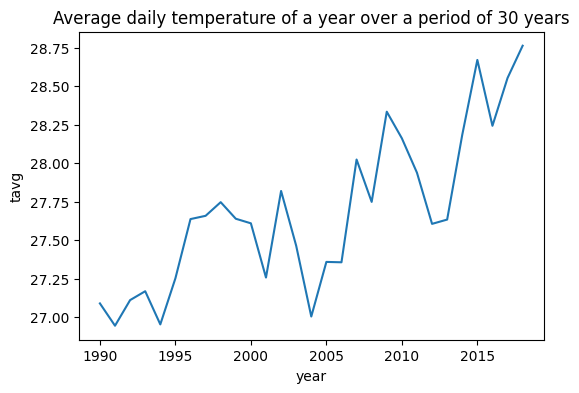

In [21]:
#Investigate how the average daily temperature has changed over the course of 30 years 
plt.figure(figsize=(6,4))
plt.title('Average daily temperature of a year over a period of 30 years')
sns.lineplot(x=average_yearly_temp.index,y = average_yearly_temp.tavg)

We can clearly see the average daily temperature in a year rise in the last decade.Let's investigate other parameters before landing on a conclusion. We can split the 'average_monthly' dataframe into 3 major seasons and check for variation of average temperatures in those 3 seasons over the course of 3 decades.

****VARIATION OF TEMPERATURE OVER SUMMER,RAINY AND WINTER SEASONS****

In [22]:
#Seperate the monthly data based on seasons
#since summer in Mumbai is from March to May we filter them out
#We will use boolean values to filter the values 
summer =(average_monthly['month'] >= 3) & (average_monthly['month'] <=5)
df_summer = average_monthly[summer]
df_summer.head()

,month,year,tmin,tmax,tavg
58,3,1990,20.362473,31.016129,25.645161
59,3,1991,20.222581,32.009140,26.225806
60,3,1992,20.500968,32.974086,26.941935
61,3,1993,21.104194,32.350538,26.664516
62,3,1994,21.291935,33.575914,27.629032


In [23]:
#Monsoon is in months June,July,August,September
monsoon = (average_monthly['month']>=6) & (average_monthly['month']<=9)
df_monsoon = average_monthly[monsoon]

We can treat the remaining of the months as Winter.October month is not precisely when winter begins in Mumbai,neither does it have regular showers.Months October and March experience a combination of weathers in a single month and hence we can include them in either of the seasons.Here, we have included them in winter 

In [24]:
#Store the indices of summer and monsoon as sets respectively
summer_set = set(df_summer.index)
monsoon_set = set(df_monsoon.index)

#set of indices of all values in average monthly Dataframe 
all_set = set(average_monthly.index)

#Obtain the indices of all values not included in summer and monsoon dataframe
winter_set_index = list(all_set - (summer_set | monsoon_set))

#use the above indices to filter the dataframe 
winter_df = pd.DataFrame(average_monthly,index =winter_set_index)

In [25]:
#set up our plot format
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

C:\Users\Vrashank\AppData\Local\Temp\ipykernel_13276\1078350978.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


**1) AVERAGE MIN,MAX,AVG TEMPERATURE IN SUMMER SEASON**

Text(0.5, 1.0, 'Average min,max,avg of summer season over 30 years')

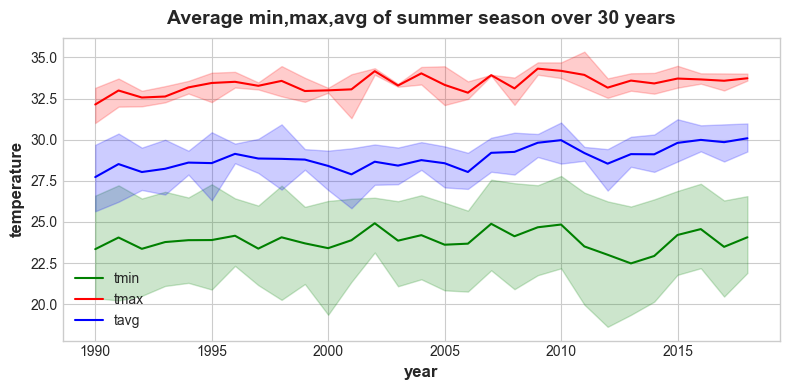

In [26]:
plt.figure(figsize=(8,4))
sns.lineplot(x=df_summer.year , y=df_summer.tmin,color='green',label='tmin')
sns.lineplot(x=df_summer.year , y=df_summer.tmax,color='red',label='tmax')
sns.lineplot(x=df_summer.year , y=df_summer.tavg,color='blue',label='tavg')
plt.ylabel('temperature')
plt.title('Average min,max,avg of summer season over 30 years')


The years after 2018 are the only ones to have minimum temperature in summer season above 25 degrees. The maximum temperature in summer season does not show a linear trend but the temperature has not dipped below 32.5 in 21st century and we can cleary see a 1-1.5 degree rise in temperature since 1990. The average daily temperature in summer season is the best evidence for the increase in temperature as we can clearly see a gradual increase of 2.5 degrees over the last 30 years.

**2) AVERAGE MIN,MAX,AVG TEMPERATURE IN WINTER**

Text(0.5, 1.0, 'Average min,max,avg of monsoon over 30 years')

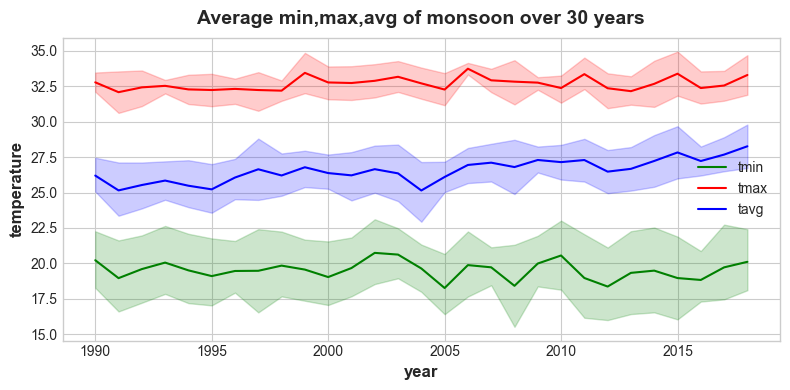

In [27]:
plt.figure(figsize=(8,4))
sns.lineplot(x=winter_df.year , y=winter_df.tmin,color='green',label='tmin')
sns.lineplot(x=winter_df.year , y=winter_df.tmax,color='red',label='tmax')
sns.lineplot(x=winter_df.year , y=winter_df.tavg,color='blue',label='tavg')
plt.ylabel('temperature')
plt.title('Average min,max,avg of monsoon over 30 years')

2022 data of winter is missing, hence we can disregard the taper after 2021. Disregarding that, the average daily temperature in winters has gone up by 1 degree, the average minimum temperature in winter by 1.5 degree, while the average maximum temperature has remained the same 

**3) AVERAGE MIN,MAX,AVG TEMPERATURE IN MONSOON**

Text(0.5, 1.0, 'Average min,max,avg of winter over 30 years')

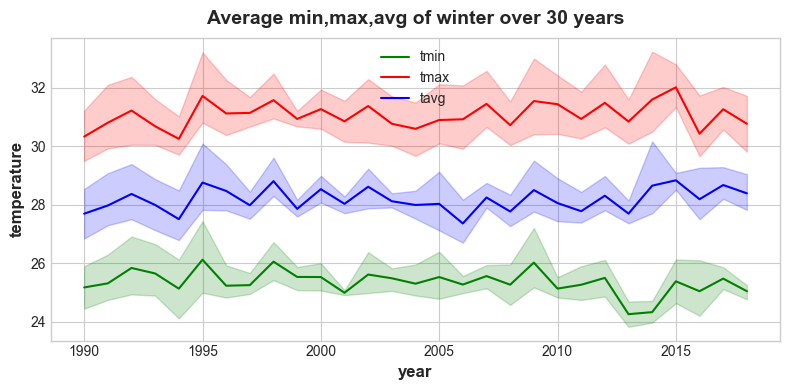

In [28]:
plt.figure(figsize=(8,4))
sns.lineplot(x=df_monsoon.year , y=df_monsoon.tmin,color='green',label='tmin')
sns.lineplot(x=df_monsoon.year , y=df_monsoon.tmax,color='red',label='tmax')
sns.lineplot(x=df_monsoon.year , y=df_monsoon.tavg,color='blue',label='tavg')
plt.ylabel('temperature')
plt.title('Average min,max,avg of winter over 30 years')

There isn't much variation in temperature during monsoon season. The min,max,average temperatures are all within 5 degrees of each other. No clear conclusions can be drawn from the above chart.

### Time Series Analysis

Using time series analysis lets try to capture the variability of the three tempatures(min,max,avg) of a year over the 3 decades and fit a model ****(regression)**** to predict the average yearly temperature for next few years. We are aware that the average yearly temperature depends on various other factors like vehicle emmisions, greenhouse gases from agriculture and poultry,deforestation etc. But these factors are outside the scope of the current dataset. Hence, this analysis will only capture the ****serial dependence**** of the temperature variation whereas in reality its a combination of time and serial dependence. 


In [29]:
df_analyze_train = average_yearly_temp
df_analyze_train.head()

,tavg,tmin,tmax
year,,,
1990,27.088283,22.670918,31.807963
1991,26.943196,22.364662,31.894027
1992,27.109836,22.628434,32.068133
1993,27.167489,22.871685,31.938306
1994,26.951781,22.497388,31.840667


We create seperate dataframe for the three variables for both test and train set ,to extract trends by creating rolling average plot.This will smooth out short term variations and uncover the overall trend 

In [32]:
#Seperating Tavg from other variables from both test and train data 
df_tavg_test = pd.DataFrame(df_analyse_test['tavg'])
df_tavg_train = pd.DataFrame(df_analyze_train["tavg"])
df_tmin_train = pd.DataFrame(df_analyze_train['tmin'])
df_tmax_train = pd.DataFrame(df_analyze_train['tmax'])

<AxesSubplot: xlabel='year', ylabel='tavg'>

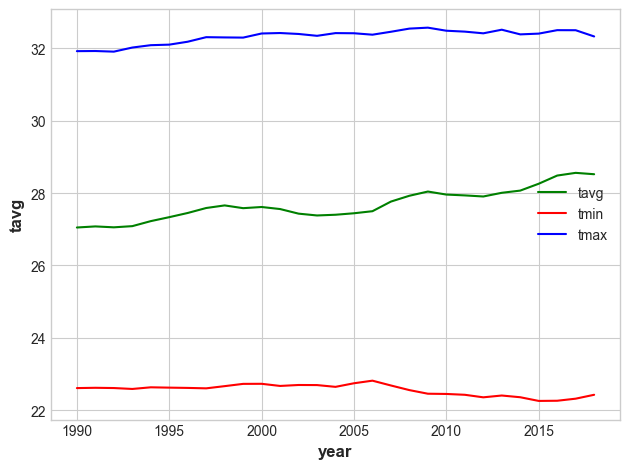

In [33]:
#Rolling averages plot to smoothen out the variation 
trend_tavg = df_tavg_train.rolling(window=5,
                          center=True,
                          min_periods=2).mean()
trend_tmin = df_tmin_train.rolling(window=9,
                          center=True,
                          min_periods=4).mean()
trend_tmax = df_tmax_train.rolling(window=5,
                          center=True,
                          min_periods=2).mean()
sns.lineplot(x=average_yearly_temp.index , y=trend_tavg['tavg'],color='green',label='tavg')
sns.lineplot(x=average_yearly_temp.index, y=trend_tmin['tmin'], color='red',label='tmin')
sns.lineplot(x=average_yearly_temp.index, y =trend_tmax['tmax'] ,color='blue',label='tmax')

Only tavg shows a clear linear trend. Since linear regression is best known to capture a trend in a time series ,we can build such model and have it forecast tavg for 5 years. 

In [34]:
#create trend variable as a feature for forecasting with 4 steps for forecast (2019-2022)
from statsmodels.tsa.deterministic import DeterministicProcess
y_avg = trend_tavg['tavg']
dp = DeterministicProcess(order = 1, index =trend_tavg.index)
X_avg = dp.in_sample()
#Five year forecast 
X_fore = dp.out_of_sample(steps = 4)

In [35]:
#linear Regression is great at capturing trends 
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_avg,y_avg)
#Store the results of the model in dataframe
y_pred = pd.DataFrame(model.predict(X_avg), index=X_avg.index,columns = ['tavg_predicted'])
y_fore = pd.DataFrame(model.predict(X_fore), index=X_fore.index,columns = ['tavg_forecast'])

In [36]:
#Error for Tavg 
Forecasted_Actual = pd.concat([df_tavg_test,y_fore],axis=1)
Forecasted_Actual['Error'] = Forecasted_Actual['tavg'] - Forecasted_Actual['tavg_forecast']
Forecasted_Actual
MeanError_Tavg = Forecasted_Actual['Error'].mean()
print("Mean Error for Tavg is {:.3f} degree celcius".format(MeanError_Tavg))

Mean Error for Tavg is -0.098 degree celcius


We calculated the error of the model and its impressively accurate. Hence we can forecast following 5 years of Average Temperature of the whole year based on the model above 

In [37]:
#Forecast for 9 years (2019-2027)
X_forecast = dp.out_of_sample(steps = 9)
y_forecast = pd.DataFrame(model.predict(X_forecast), index=X_forecast.index,columns = ['tavg_forecast'])

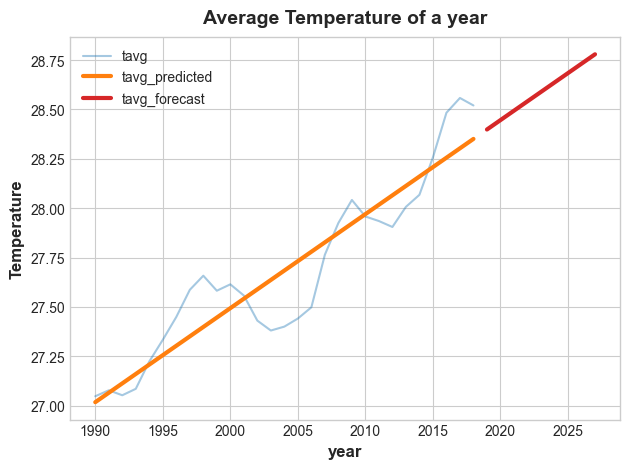

In [38]:
#Plot the forecast captured by regression model 
ax = y_avg.plot(alpha=0.4, title="Average Temperature of a year", ylabel="Temperature")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C1')
ax = y_forecast.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

The above plot clearly indicates an increase in average temperature in the next five years. This forecast in purely based on serial dependence but can a decent indicator for whats to come. Let's draw accurate numerical conclusions from the above model by comparing temperatures of 2027 to 1990 and 2022    

In [39]:
#Store value of forecasted 2027 avg temperature 
tavg_forecast_2027 = float(y_forecast[y_forecast.index == 2027]['tavg_forecast'])

#Store Values of 1990 and 2022 
tavg_actual_1990 = float(df_analyze_train[df_analyze_train.index == 1990]['tavg'])
tavg_actual_2022 = float(df_analyse_test[df_analyse_test.index == 2022]['tavg'])

### Temperature Variations 

In [40]:
print("The average daily temperature of a year is predicted to rise by {:.3f} degree in the next 5 years".format(tavg_forecast_2027 - tavg_actual_2022))

The average daily temperature of a year is predicted to rise by 0.442 degree in the next 5 years


In [41]:
print("The mean absolute error of our regression model is {:.3f}".format(MeanError_Tavg))

The mean absolute error of our regression model is -0.098


In [42]:
print("The difference between average daily temperature of a year between 1990 and 2027 is {:.3f} degrees".format(tavg_forecast_2027 -tavg_actual_1990))

The difference between average daily temperature of a year between 1990 and 2027 is 1.691 degrees


In [43]:
print("There's a conclusive rise in temperature of {:.3f} degrees between years 1990 and 2022".format(tavg_actual_2022-tavg_actual_1990))

There's a conclusive rise in temperature of 1.250 degrees between years 1990 and 2022


###Findings


* Average temperature of the day of summer saw a rise of **2.5 degrees** from 27.5 to 30 degrees in the last 3 decades. 
* Though small there is a rise of average daily temperature in rainy and winter seasons too 
* Minimum and maximum temperatures of all seasons were fluctuating without any clear rise or decline 
* Even after considering just a single variable (temperature) we can successfully catpure an overall increase in average temperature through the period of 3 decades.
* Not only can we capture the change but also a model a linear regression that forecasts a **0.442 degrees** of increase in the next 5 years.
* The accuracy of the model could be better if other factors were considered since regression is capable of multi-output model.
* But the **error of the model** is extremely small(though small test size) **-0.0982**
* Our regression model aside there's non-refutable rise of **1.25 degrees** in average temperature of a year between period **1990 and 2022.**
